# Calculate radiative response of abrupt-4xCO2 experiment with the radiatvie kernel 

In [1]:
import numpy as np
import subprocess
import xarray as xr
import numba
from numba import njit

import matplotlib.pyplot as plt
%matplotlib inline

import Radiative_Repsonse_with_Raditive_kernel as r3k

## Prepare the data 
> in both perturbation (abrupt-4xCO2) and control (piControl)
 - __ta(3D), hus(3D), ts(2D)__:  \
> $dt = T_{per} - T_{con}  $
 - __rlut rsdt rsut__ : 
 - __rsutcs rlutcs__: 
> clear-sky data needed in both perturbation (abrupt-4xCO2) and control (piControl) \
>  we infer the forcing in all-sky condition\
> $D = D^0/1.16$

In [2]:
experiments = ["piControl","abrupt-4xCO2"]
# experiments = ["piControl","1pctCO2"]

var_list = "ta hus ts rlut rsdt rsut rlutcs rsutcs rsus rsds".split()
res_hori = '2x2.5'
## run the regrid scripts before this one!
dvc_info = '2020051522'

In [3]:
# def decompose_RK(model)
# process for each model
model = 'GFDL-CM4'
# model = 'CESM2'
var_cont = {}
var_pert = {}
model_ava = []
# read  all var needed
print(">>> start "+model)
for var in var_list:
    print(">>> reading <var>|{0:>7s}".format(var) )
    try:
        fpath = f"./data/piControl/{model}/{var}.mon.0001-0450.ltm.nc.{dvc_info}.2x2.5"
        with xr.open_dataset(fpath) as ds:
            var_cont[var] =  ds.isel(model=0).load()
    except:
        print(f"Error reading data: {fpath}")
        raise 
    try:
        fpath = f"./data/abrupt-4xCO2/{model}/{var}.mon.0001-0150.nc.{dvc_info}.2x2.5"
        with xr.open_dataset(fpath) as ds:
            var_pert[var] =  ds.isel(model=0).load()
    except:
        print(f"Error reading data: {fpath}")
        raise


>>> start GFDL-CM4
>>> reading <var>|     ta
>>> reading <var>|    hus
>>> reading <var>|     ts
>>> reading <var>|   rlut
>>> reading <var>|   rsdt
>>> reading <var>|   rsut
>>> reading <var>| rlutcs
>>> reading <var>| rsutcs
>>> reading <var>|   rsus
>>> reading <var>|   rsds


In [4]:
## import kernel file and compute: dR_wv, dR_T, dR_Ts, dR_alb + clear sky
rk_source = 'GFDL'
# kernel file is from  https://climate.rsmas.miami.edu/data/radiative-kernels/index.html
fpath = "./data/kernels_TOA_"+rk_source+"_CMIP6-standard.nc"
f_RK =  xr.open_dataset(fpath,decode_times=False) 
f_RK=f_RK.rename({'time': 'month'})
f_RK.coords['month']= np.arange(1,13,1)
f_RK.coords['plev']= f_RK.coords['plev']*100

## time benchmark  (test with GFDL-CM4)
- compile and parallel with numba ~ 10s
- pure xarray ~ 100s

In [5]:
%%time
# run with dummy data to compile the jit functions and speed up the computation
# see https://numba.pydata.org/numba-doc/latest/index.html for detail
dummy_TPLL = np.random.rand(36,2,3,4).astype('float32')
dummy_TPLL12 = np.random.rand(12,2,3,4).astype('float32')
dummy_TLL = np.random.rand(36,3,4).astype('float32')
dummy_TLL12 = np.random.rand(12,3,4).astype('float32')
dummy_plev = np.random.rand(2).astype('float32')
r3k.diff_pert_mon_cont_12mon_TPLL_fast(dummy_TPLL, dummy_TPLL12)
r3k.diff_pert_mon_cont_12mon_TLL_fast(dummy_TLL, dummy_TLL12)
r3k.alb_diff_pert_mon_cont_12mon_TLL_fast(dummy_TLL, dummy_TLL, dummy_TLL12, dummy_TLL12)
r3k.omega_wv_fast(dummy_TPLL, dummy_TPLL12, dummy_TPLL12)
r3k.RK_compute_TLL_fast (dummy_TLL, dummy_TLL12)
r3k.RK_compute_TPLL_plev_fast(dummy_TPLL, dummy_TPLL12, dummy_plev)
print("@njit Functions  compiled")

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


@njit Functions  compiled
CPU times: user 17 s, sys: 238 ms, total: 17.2 s
Wall time: 6.54 s


In [6]:
%%time
# numba version (fast, will be 10x faster if run it after compiled)
## convert the hus for RK and calculate the dR_wv
ta_anom  = r3k.diff_pert_mon_cont_12mon_TPLL_fast(var_pert['ta'].ta.values, var_cont['ta'].ta.values)
ts_anom  = r3k.diff_pert_mon_cont_12mon_TLL_fast (var_pert['ts'].ts.values, var_cont['ts'].ts.values)
alb_anom = r3k.alb_diff_pert_mon_cont_12mon_TLL_fast(var_pert['rsus'].rsus.values, var_pert['rsds'].rsds.values,
                                                      var_cont['rsus'].rsus.values, var_cont['rsds'].rsds.values)
omega_wv = r3k.omega_wv_fast (var_pert['hus'].hus.values, var_cont['hus'].hus.values, var_cont['ta'].ta.values)
dR_sw   = r3k.diff_pert_mon_cont_12mon_TLL_fast((var_pert['rsdt'].rsdt.values-var_pert['rsut'].rsut.values),
                                                 (var_cont['rsdt'].rsdt.values-var_cont['rsut'].rsut.values) )
dR_lw   = r3k.diff_pert_mon_cont_12mon_TLL_fast((-var_pert['rlut'].rlut.values),
                                                 (-var_cont['rlut'].rlut.values) )
dRcs_sw = r3k.diff_pert_mon_cont_12mon_TLL_fast((var_pert['rsdt'].rsdt.values-var_pert['rsutcs'].rsutcs.values),
                                                 (var_cont['rsdt'].rsdt.values-var_cont['rsutcs'].rsutcs.values) )
dRcs_lw = r3k.diff_pert_mon_cont_12mon_TLL_fast((-var_pert['rlutcs'].rlutcs.values),
                                                 (-var_cont['rlutcs'].rlutcs.values) )
plev_weight = r3k.RK_plev_weight(var_cont['hus'].hus.plev.values)
dR_wv_lw    = r3k.RK_compute_TPLL_plev_fast(omega_wv,f_RK.lw_q.values.astype('float32'),    plev_weight)
dR_wv_sw    = r3k.RK_compute_TPLL_plev_fast(omega_wv,f_RK.sw_q.values.astype('float32'),    plev_weight)
dR_wvcs_lw  = r3k.RK_compute_TPLL_plev_fast(omega_wv,f_RK.lwclr_q.values.astype('float32'), plev_weight)
dR_wvcs_sw  = r3k.RK_compute_TPLL_plev_fast(omega_wv,f_RK.swclr_q.values.astype('float32'), plev_weight)
dR_Ta       = r3k.RK_compute_TPLL_plev_fast(ta_anom, f_RK.lw_ta.values.astype('float32'),   plev_weight)
dR_Tacs     = r3k.RK_compute_TPLL_plev_fast(ta_anom, f_RK.lwclr_ta.values.astype('float32'),plev_weight)
dR_Ts       = r3k.RK_compute_TLL_fast (ts_anom,f_RK.lw_ts.values.astype('float32'))
dR_Tscs     = r3k.RK_compute_TLL_fast (ts_anom,f_RK.lwclr_ts.values.astype('float32'))
dR_alb      = r3k.RK_compute_TLL_fast (alb_anom,f_RK.sw_alb.values.astype('float32'))
dR_albcs    = r3k.RK_compute_TLL_fast (alb_anom,f_RK.swclr_alb.values.astype('float32'))

## dR due to cloud change
Dcs_lw   = dRcs_lw - (dR_Tacs - dR_Tscs - dR_wvcs_lw)
Dcs_sw   = dRcs_sw - (- dR_albcs - dR_wvcs_sw)
D_lw     = Dcs_lw / 1.16
D_sw     = Dcs_sw / 1.16
dR_c_lw  = dR_lw - D_lw - (dR_Ta - dR_Ts - dR_wv_lw)
dR_c_sw  = dR_sw - D_sw - (- dR_alb - dR_wv_sw)
np.nanmean(dR_c_lw+dR_c_sw)

CPU times: user 36.8 s, sys: 5.32 s, total: 42.1 s
Wall time: 4.15 s


1.7821074

In [7]:
%%time
# xarray version (slow but easy to understand and modify)

ta_anom0 = var_pert['ta'].ta.groupby('time.month') - var_cont['ta'].ta
omega_wv0 = r3k.omega_wv_xarray (var_pert['hus'].hus, var_cont['hus'].hus, var_cont['ta'].ta)
#### dt, dts, omega_wv, dRt_l, dRt_s, dRt_lcs, dRt_scs
ts_anom0 = var_pert['ts'].ts.groupby('time.month') - var_cont['ts'].ts
alb_pert = var_pert['rsus'].rsus/var_pert['rsds'].rsds
alb_pert = alb_pert.where(np.isfinite(alb_pert),0)
alb_cont = var_cont['rsus'].rsus/var_cont['rsds'].rsds
alb_cont = alb_cont.where(np.isfinite(alb_cont),0)
alb_anom_0 = alb_pert.groupby('time.month') - alb_cont
dR0   = (var_pert['rsdt'].rsdt-var_pert['rsut'].rsut-var_pert['rlut'].rlut).groupby('time.month') \
       -(var_cont['rsdt'].rsdt-var_cont['rsut'].rsut-var_cont['rlut'].rlut)
dRcs0 = (var_pert['rsdt'].rsdt-var_pert['rsutcs'].rsutcs-var_pert['rlutcs'].rlutcs).groupby('time.month') \
       -(var_cont['rsdt'].rsdt-var_cont['rsutcs'].rsutcs-var_cont['rlutcs'].rlutcs)
#### dR_wv, dR_T, dR_Ts, dR_alb + clear sky
dR_wv0    = r3k.RK_compute_TPLL(omega_wv0,f_RK.lw_q+f_RK.sw_q)
dR_wvcs0  = r3k.RK_compute_TPLL(omega_wv0,f_RK.lwclr_q+f_RK.swclr_q)
dR_Ta0    = r3k.RK_compute_TPLL(ta_anom0,f_RK.lw_ta)
dR_Tacs0  = r3k.RK_compute_TPLL(ta_anom0,f_RK.lwclr_ta)
dR_Ts0    = r3k.RK_compute_suf (ts_anom0,f_RK.lw_ts)
dR_Tscs0  = r3k.RK_compute_suf (ts_anom0,f_RK.lwclr_ts)
dR_alb0   = r3k.RK_compute_suf (alb_anom_0*100,f_RK.sw_alb)
dR_albcs0 = r3k.RK_compute_suf (alb_anom_0*100,f_RK.swclr_alb)
D_00   = dRcs0 - (dR_Tacs0 - dR_Tscs0 - dR_albcs0 - dR_wvcs0)
D0     = D_00 / 1.16
dR_c0  = dR0 - D0 - (dR_Ta0 - dR_Ts0 - dR_alb0 - dR_wv0)
print(dR_c0.mean().values)

/Users/chenggong/miniconda3/envs/r3k_env/lib/python3.10/site-packages/xarray/core/computation.py:733: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/Users/chenggong/miniconda3/envs/r3k_env/lib/python3.10/site-packages/xarray/core/computation.py:733: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


1.7903143524217626
CPU times: user 42.7 s, sys: 51 s, total: 1min 33s
Wall time: 1min 51s


In [8]:

## write to file
ds_write = xr.Dataset()
time_ds = var_pert['ts'].time
ds_write.coords['time'] = time_ds
ds_write.coords['lat']  = var_pert['ts'].lat
ds_write.coords['lon']  = var_pert['ts'].lon

ds_write['dR_wv_lw'] = (('time','lat','lon'),dR_wv_lw)
ds_write['dR_wv_sw'] = (('time','lat','lon'),dR_wv_sw)
ds_write['dR_wvcs_lw'] = (('time','lat','lon'),dR_wvcs_lw)
ds_write['dR_wvcs_sw'] = (('time','lat','lon'),dR_wvcs_sw)
ds_write['dR_Ta'] = (('time','lat','lon'),dR_Ta)
ds_write['dR_Tacs'] = (('time','lat','lon'),dR_Tacs)
ds_write['dR_Ts'] = (('time','lat','lon'),dR_Ts)
ds_write['dR_Tscs'] = (('time','lat','lon'),dR_Tscs)
ds_write['dR_alb'] = (('time','lat','lon'),dR_alb)
ds_write['dR_albcs'] = (('time','lat','lon'),dR_albcs)
ds_write['dR_c_lw'] = (('time','lat','lon'),dR_c_lw)
ds_write['dR_c_sw'] = (('time','lat','lon'),dR_c_sw)
ds_write['Dcs_lw'] = (('time','lat','lon'),Dcs_lw)
ds_write['Dcs_sw'] = (('time','lat','lon'),Dcs_sw)
ds_write['dR_sw'] = (('time','lat','lon'),dR_sw)
ds_write['dR_lw'] = (('time','lat','lon'),dR_lw)
ds_write['dRcs_sw'] = (('time','lat','lon'),dRcs_sw)
ds_write['dRcs_sw'] = (('time','lat','lon'),dRcs_sw)
ds_write['dts'] = (('time','lat','lon'),ts_anom)
#file size GB
print(ds_write.nbytes/1e9)

# save the rk results for future use
# out_filename = 'rk.test.toa'
# print(out_filename)
# ds_write.to_netcdf(out_filename)

1.679632304


# Plot results

In [9]:

def global_mean_xarray(ds_XXLL):
    """ 
    Compute the global mean value of the data.
    The data has to have the lat and lon in its dimensions.
    
    Parameters
    ----------
    ds_XXLL   : xarray with lat and lon. ds_XXLL.lat will be 
                used for area weight.

    Returns
    ----------
    tmp_XX    : xarray without lat and lon.
    
    """
    lat = ds_XXLL.coords['lat']        # readin lat
    # global mean
    # compute cos(lat) as a weight function
    weight_lat = np.cos(np.deg2rad(lat))/np.mean(np.cos(np.deg2rad(lat)))
    tmp_XXL = ds_XXLL.mean(dim=['lon'])*weight_lat
    tmp_XX  = tmp_XXL.mean(dim=['lat'])
    return tmp_XX

In [10]:
dR_temp_gm = global_mean_xarray(ds_write['dR_Ta']+ds_write['dR_Ts']).groupby('time.year').mean()
dR_clou_gm = global_mean_xarray(ds_write['dR_c_lw']+ds_write['dR_c_sw']).groupby('time.year').mean()
dR_wv_gm = global_mean_xarray(ds_write['dR_wv_lw']+ds_write['dR_wv_sw']).groupby('time.year').mean()
dR_albe_gm = global_mean_xarray(ds_write['dR_alb']).groupby('time.year').mean()
dts_gm = global_mean_xarray(ds_write['dts']).groupby('time.year').mean()

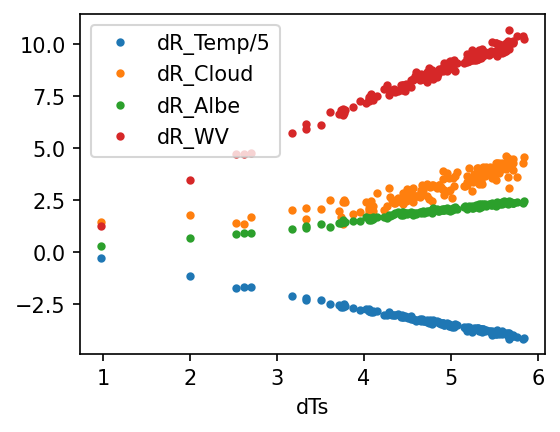

In [11]:
plt.close()
fig0 = plt.figure(figsize=(4,3),dpi=150)
ax1   = fig0.add_subplot(111)
ax1.plot(dts_gm,dR_temp_gm/5,'.',label='dR_Temp/5')
ax1.plot(dts_gm,dR_clou_gm,'.',label='dR_Cloud')
ax1.plot(dts_gm,dR_albe_gm,'.',label='dR_Albedo')
ax1.plot(dts_gm,dR_wv_gm,'.',label='dR_WV')
ax1.set_xlabel('dTs')
plt.legend()
plt.show()